# Improved L2 CNN→LSTM Model (ETH/BTC 5s L2) — Multi-Horizon (5m + 10m)

This notebook is a cleaned-up and **more evaluation-safe** version of the original `simple_l2_cnn.ipynb`.

Key upgrades:
- **Multi-horizon experiments:** 5-minute and 10-minute
- **Dynamic triple-barrier labels** (volatility-scaled)
- **3-class training:** SELL / HOLD / BUY (**no dropping HOLD**)
- **Stride sampling** (reduces near-duplicate windows)
- **Embargo / purge split** (reduces leakage around the train/val boundary)
- **Tail-based "committee-style" trading eval** + simple cost model

Data is assumed to be a local CSV at:
`../data/5s_data/eth_btc_5s_l2_data.csv`

In [162]:
# If you need installs, uncomment:
# !pip install -q pandas numpy matplotlib tqdm scikit-learn tensorflow

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.rcParams["figure.figsize"] = (14, 4)
pd.set_option("display.max_columns", 200)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.18.0


## 0) Configuration

In [163]:
DATA_PATH = Path("../data/5s_data/eth_btc_5s_l2_data.csv")

STEP_SECONDS = 5  # your data is 5-second snapshots
SEQUENCE_LENGTH = 100  # lookback window (100 steps = 500s ≈ 8.3m)
L2_DEPTH_LEVELS = 8    # use top N levels

# Run experiment at this horizon (minutes)
HORIZON_MINUTES = 5
LOOKAHEAD_STEPS = int(HORIZON_MINUTES * 60 / STEP_SECONDS)

# Dynamic triple barrier label: threshold = max(min_thr, multiplier * rolling_vol)
VOL_WINDOW = 100         # ~8–10 minutes of 5s snapshots
VOL_MULTIPLIER = 1.0     # 1.0σ move target
MIN_THRESHOLD = 0.0005   # 5 bps minimum to avoid tiny-noise labels
TIMEOUT_MINUTES = 2      # timeout to HOLD if no barrier hit (should be < HORIZON_MINUTES)

# Sequence creation
STRIDE_STEPS = 6         # create a sample every 6 steps (30 seconds) to reduce overlap

# Chronological split
TRAIN_FRAC = 0.70
VAL_FRAC = 0.15  # remaining 0.15 will be test
# Embargo to reduce leakage: lookahead + lookback (per horizon)
EMBARGO_EXTRA = 0        # add extra buffer if you want

# Committee-style trading decision thresholds (tune)
P_HOLD_MAX = 0.35
P_SIDE_MIN = 0.45
P_MARGIN_MIN = 0.15

LONG_SHORT = True  # if False, SHORT signals become abstain

# Costs (very rough): applied per non-zero trade
COST_BPS = 4.0

# Training
BATCH_SIZE = 256
EPOCHS = 40
EARLY_STOP_PATIENCE = 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("Horizon (min):", HORIZON_MINUTES)


print("Timeout steps:", int(TIMEOUT_MINUTES * 60 / STEP_SECONDS))
print("Timeout (min):", TIMEOUT_MINUTES)
print("Lookahead steps:", LOOKAHEAD_STEPS)

Horizon (min): 5
Timeout steps: 24
Timeout (min): 2
Lookahead steps: 60


## 1) Load data

In [164]:
print(f"Loading: {DATA_PATH}")
df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()

Loading: ../data/5s_data/eth_btc_5s_l2_data.csv
Raw shape: (324350, 85)
Raw shape: (324350, 85)


,timestamp,ETH_price,ETH_volume,ETH_bid_price_1,ETH_bid_vol_1,ETH_ask_price_1,ETH_ask_vol_1,ETH_bid_price_2,ETH_bid_vol_2,ETH_ask_price_2,ETH_ask_vol_2,ETH_bid_price_3,ETH_bid_vol_3,ETH_ask_price_3,ETH_ask_vol_3,ETH_bid_price_4,ETH_bid_vol_4,ETH_ask_price_4,ETH_ask_vol_4,ETH_bid_price_5,ETH_bid_vol_5,ETH_ask_price_5,ETH_ask_vol_5,ETH_bid_price_6,ETH_bid_vol_6,ETH_ask_price_6,ETH_ask_vol_6,ETH_bid_price_7,ETH_bid_vol_7,ETH_ask_price_7,ETH_ask_vol_7,ETH_bid_price_8,ETH_bid_vol_8,ETH_ask_price_8,ETH_ask_vol_8,ETH_bid_price_9,ETH_bid_vol_9,ETH_ask_price_9,ETH_ask_vol_9,ETH_bid_price_10,ETH_bid_vol_10,ETH_ask_price_10,ETH_ask_vol_10,BTC_price,BTC_volume,BTC_bid_price_1,BTC_bid_vol_1,BTC_ask_price_1,BTC_ask_vol_1,BTC_bid_price_2,BTC_bid_vol_2,BTC_ask_price_2,BTC_ask_vol_2,BTC_bid_price_3,BTC_bid_vol_3,BTC_ask_price_3,BTC_ask_vol_3,BTC_bid_price_4,BTC_bid_vol_4,BTC_ask_price_4,BTC_ask_vol_4,BTC_bid_price_5,BTC_bid_vol_5,BTC_ask_price_5,BTC_ask_vol_5,BTC_bid_price_6,BTC_bid_vol_6,BTC_ask_price_6,BTC_ask_vol_6,BTC_bid_price_7,BTC_bid_vol_7,BTC_ask_price_7,BTC_ask_vol_7,BTC_bid_price_8,BTC_bid_vol_8,BTC_ask_price_8,BTC_ask_vol_8,BTC_bid_price_9,BTC_bid_vol_9,BTC_ask_price_9,BTC_ask_vol_9,BTC_bid_price_10,BTC_bid_vol_10,BTC_ask_price_10,BTC_ask_vol_10
0,2025-12-21 18:16:07.574055,2969.90,31338.713240,2969.87,0.003145,2969.88,6.540193,2969.70,0.001000,2969.89,0.168357,2969.55,0.001000,2969.90,0.183000,2969.48,0.374471,2969.94,0.207571,2969.40,0.001000,2970.00,0.124000,2969.25,0.001000,2970.20,0.124000,2969.20,0.100000,2970.30,0.169338,2969.19,0.908431,2970.36,0.354589,2969.18,0.512000,2970.40,0.124000,2969.12,0.058943,2970.44,0.001680,87979.56,2115.143864,87976.18,0.000049,87979.58,0.000083,87976.17,0.012620,87979.59,0.029237,87976.00,4.800000e-03,87979.60,0.010000,87975.00,0.000122,87979.61,0.022733,87974.99,0.011367,87980.00,0.005100,87974.00,0.004800,87981.12,0.000013,87972.00,0.004800,87981.25,0.002270,87970.01,1.643673e-02,87982.00,0.005100,87970.00,4.800000e-03,87983.01,0.002270,87969.71,0.022732,87983.69,0.010000
1,2025-12-21 18:16:12.817972,2969.88,31347.880067,2969.87,0.001523,2969.88,2.115605,2969.56,0.168375,2969.89,0.168357,2969.55,0.001000,2969.90,0.124000,2969.48,0.374471,2969.93,0.059000,2969.40,0.001000,2970.00,0.124000,2969.25,0.048835,2970.09,0.204091,2969.24,0.105692,2970.10,0.124000,2969.22,0.125167,2970.13,0.001873,2969.21,0.089251,2970.14,0.106921,2969.19,1.403813,2970.15,0.365282,87982.00,2119.345015,87978.38,0.009700,87981.72,0.000022,87978.37,0.009748,87981.73,0.010204,87978.34,1.136643e-01,87984.00,0.005400,87978.11,0.003410,87985.80,0.001822,87978.02,0.010004,87986.00,0.012221,87978.00,0.000066,87986.53,0.002270,87976.00,0.004800,87986.56,0.000013,87975.77,1.717038e-02,87987.20,0.051011,87975.76,2.396110e-02,87987.21,0.093420,87974.00,0.004800,87987.64,0.032935
2,2025-12-21 18:16:17.863189,2970.49,31328.356672,2970.58,0.001593,2970.59,0.156291,2970.33,0.168331,2970.60,0.458838,2970.02,0.100000,2970.62,0.002041,2970.01,0.253600,2970.63,1.683754,2970.00,1.932815,2970.70,0.118000,2969.96,0.358210,2970.74,0.168308,2969.89,1.911828,2970.75,0.001000,2969.88,0.975000,2970.78,0.123607,2969.86,0.063000,2970.79,0.656700,2969.85,0.380971,2970.80,0.124000,87991.99,2118.773992,87991.99,0.051389,87992.00,0.000013,87990.00,0.004800,87992.89,0.035244,87984.00,4.800000e-03,87996.00,0.004800,87982.01,0.011512,87997.31,0.000050,87982.00,0.004800,87997.32,0.014403,87981.64,0.001136,87997.44,0.000013,87980.04,0.007367,87997.80,0.052086,87979.76,7.800000e-07,88002.03,0.068000,87978.11,3.409920e-03,88002.04,0.005600,87978.00,0.000066,88002.06,0.093420
3,2025-12-21 18:16:22.807019,2970.22,31338.713240,2970.48,0.001543,2970.49,2.223427,2970.22,0.179197,2970.50,0.639471,2970.15,0.001000,2970.53,0.168320,2970.11,0.168344,2970.60,0.124000,2969.96,0.000077,2970.61,0.000431,2969.88,0.100000,2970.62,1.684944,2969.87,1.141361,2970.63,1.683754,2969.86,1.911828,2970.70,0.124000,2969.85,0.729714,2970.75,0.976000,2969.74,0.347600,2970.76,0.518581,

In [165]:
# Timestamp parsing (assume already sorted, but we enforce it)
if "timestamp" in df_raw.columns:
    df_raw["timestamp"] = pd.to_datetime(df_raw["timestamp"], errors="coerce", utc=True)
    df_raw = df_raw.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
else:
    print("⚠️ No 'timestamp' column found; using row index as time.")

print("After timestamp handling:", df_raw.shape)

After timestamp handling: (324350, 85)


## 2) Feature engineering (stationary + L2 depth)

In [166]:
df = df_raw.copy()

# Core price series
if "ETH_price" not in df.columns or "BTC_price" not in df.columns:
    raise ValueError("Expected columns ETH_price and BTC_price in the CSV. Please check your schema.")

df["price"] = df["ETH_price"].astype(float)
df["btc_price"] = df["BTC_price"].astype(float)

# Returns + rolling volatility
df["ret"] = df["price"].pct_change()
df["volatility"] = df["ret"].rolling(window=VOL_WINDOW, min_periods=VOL_WINDOW).std()
df["volatility"] = df["volatility"].fillna(df["volatility"].mean())

# Log returns (more ML-friendly)
df["log_ret"] = np.log(df["price"]).diff()
df["btc_log_ret"] = np.log(df["btc_price"]).diff()

# Trade volume changes (if present)
for col in ["ETH_volume", "BTC_volume"]:
    if col not in df.columns:
        print(f"⚠️ Missing {col}; filling with 0s.")
        df[col] = 0.0
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

df["log_trade_vol"] = np.log1p(df["ETH_volume"])
df["log_trade_vol_change"] = df["log_trade_vol"].diff()

df["log_btc_vol"] = np.log1p(df["BTC_volume"])
df["log_btc_vol_change"] = df["log_btc_vol"].diff()

# Spread + OFI (top-of-book)
needed_top = ["ETH_bid_price_1", "ETH_ask_price_1", "ETH_bid_vol_1", "ETH_ask_vol_1"]
missing_top = [c for c in needed_top if c not in df.columns]
if missing_top:
    raise ValueError(f"Missing required top-of-book columns: {missing_top}")

df["spread"] = df["ETH_ask_price_1"] - df["ETH_bid_price_1"]

df["bid_vol_1_shift"] = df["ETH_bid_vol_1"].shift(1)
df["ask_vol_1_shift"] = df["ETH_ask_vol_1"].shift(1)
df["OFI"] = (df["ETH_bid_vol_1"] - df["bid_vol_1_shift"]) - (df["ETH_ask_vol_1"] - df["ask_vol_1_shift"])

# L2 depth volumes (log1p)
for i in range(1, L2_DEPTH_LEVELS + 1):
    b = f"ETH_bid_vol_{i}"
    a = f"ETH_ask_vol_{i}"
    if b not in df.columns or a not in df.columns:
        raise ValueError(f"Missing depth columns for level {i}: {b}, {a}")
    df[f"log_ETH_bid_vol_{i}"] = np.log1p(pd.to_numeric(df[b], errors="coerce").fillna(0.0))
    df[f"log_ETH_ask_vol_{i}"] = np.log1p(pd.to_numeric(df[a], errors="coerce").fillna(0.0))

# Cleanup
df = df.drop(columns=["bid_vol_1_shift", "ask_vol_1_shift", "log_trade_vol", "log_btc_vol"], errors="ignore")
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print("After feature engineering:", df.shape)
df[["price","log_ret","log_trade_vol_change","btc_log_ret","OFI","spread","volatility"]].describe()

After feature engineering: (296650, 111)


,price,log_ret,log_trade_vol_change,btc_log_ret,OFI,spread,volatility
count,296650.000000,2.966500e+05,2.966500e+05,2.966500e+05,296650.000000,296650.000000,296650.000000
mean,3035.683759,-6.119729e-08,5.723712e-08,1.444038e-09,0.029778,0.024626,0.000148
std,103.081572,1.772120e-04,4.675976e-03,1.296616e-04,79.074842,0.055693,0.000098
min,2887.700000,-4.219095e-03,-3.251239e-01,-2.664483e-03,-7583.863905,0.010000,0.000013
25%,2945.320000,-4.618633e-05,-1.742889e-05,-2.368828e-05,-0.879152,0.010000,0.000085
50%,2987.275000,0.000000e+00,0.000000e+00,0.000000e+00,0.000011,0.010000,0.000121
75%,3121.580000,4.520909e-05,8.284727e-05,2.373896e-05,0.884000,0.010000,0.000177
max,3306.330000,5.042875e-03,2.630730e-01,3.116788e-03,7814.251231,3.090000,0.000890


## 3) Dynamic triple-barrier labeling (3-class)

In [167]:
def label_triple_barrier_dynamic(prices: np.ndarray,
                                volatilities: np.ndarray,
                                lookahead: int,
                                timeout: int,
                                multiplier: float = 1.0,
                                min_thr: float = 0.0002) -> np.ndarray:
    """Return labels in {-1,0,1} for SELL/HOLD/BUY.
    
    Args:
        prices: Price array
        volatilities: Volatility array for dynamic thresholds
        lookahead: Maximum steps to look ahead (defines exit for trading)
        timeout: Steps to wait before labeling as HOLD (should be < lookahead)
        multiplier: Volatility multiplier for barrier threshold
        min_thr: Minimum threshold (prevents too-tight barriers)
    """
    n = len(prices)
    labels = np.full(n, np.nan, dtype=float)
    for i in range(n - lookahead - 1):
        p0 = prices[i]
        thr = float(multiplier * volatilities[i])
        if thr < min_thr:
            thr = min_thr
        upper = p0 * (1 + thr)
        lower = p0 * (1 - thr)

        # Check within timeout window first
        future_timeout = prices[i+1:i+1+timeout]
        hit_up_timeout = np.where(future_timeout >= upper)[0]
        hit_dn_timeout = np.where(future_timeout <= lower)[0]

        # If hit within timeout, label based on first hit
        if len(hit_up_timeout) > 0 or len(hit_dn_timeout) > 0:
            if len(hit_up_timeout) > 0 and len(hit_dn_timeout) == 0:
                labels[i] = 1
            elif len(hit_dn_timeout) > 0 and len(hit_up_timeout) == 0:
                labels[i] = -1
            else:
                labels[i] = 1 if hit_up_timeout[0] < hit_dn_timeout[0] else -1
        else:
            # No barrier hit within timeout → HOLD
            labels[i] = 0

    return labels

# quick sanity on label rates
timeout_steps = int(TIMEOUT_MINUTES * 60 / STEP_SECONDS)
labels = label_triple_barrier_dynamic(df["price"].values, df["volatility"].values,
                                     lookahead=LOOKAHEAD_STEPS, timeout=timeout_steps,
                                     multiplier=VOL_MULTIPLIER, min_thr=MIN_THRESHOLD)
vc = pd.Series(labels).value_counts(dropna=True).sort_index()
print(f"\nHorizon {HORIZON_MINUTES}m ({LOOKAHEAD_STEPS} steps), Timeout {TIMEOUT_MINUTES}m ({timeout_steps} steps):")
for k in [-1,0,1]:
    count = int(vc.get(k,0))
    pct = 100 * count / vc.sum()
    print(f"  {k:+d}: {count:6d} ({pct:.1f}%)")


Horizon 5m (60 steps), Timeout 2m (24 steps):
  -1:  90018 (30.4%)
  +0: 116043 (39.1%)
  +1:  90528 (30.5%)


## 4) Sequence builder with stride + embargo split

In [168]:
def create_sequences(X: np.ndarray, y: np.ndarray, end_prices: np.ndarray,
                     sequence_length: int, stride: int = 1):
    """Create (X_seq, y_seq, idx_seq, price0_seq, priceT_seq).
    idx_seq is the ending index i (label is y[i]).
    price0 is end_prices[i] (entry), priceT is end_prices[i+lookahead] set later.
    """
    X_seq, y_seq, idx_seq = [], [], []
    for i in range(sequence_length, len(X), stride):
        if np.isnan(y[i]):
            continue
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
        idx_seq.append(i)
    return np.array(X_seq), np.array(y_seq), np.array(idx_seq)

def embargo_split(n: int, train_frac: float, val_frac: float, embargo: int):
    """Split data into train/val/test with embargo gaps.
    
    Returns: (train_end, val_start, val_end, test_start)
    """
    train_split = int(n * train_frac)
    val_split = int(n * (train_frac + val_frac))
    
    train_end = max(0, train_split - embargo)
    val_start = min(n, train_split + embargo)
    val_end = max(val_start, val_split - embargo)
    test_start = min(n, val_split + embargo)
    
    return train_end, val_start, val_end, test_start

def map_labels_to_3class(y: np.ndarray) -> np.ndarray:
    # -1 -> 0, 0 -> 1, +1 -> 2
    out = np.full_like(y, fill_value=-1, dtype=int)
    out[y == -1] = 0
    out[y ==  0] = 1
    out[y ==  1] = 2
    return out

## 5) Model (CNN → LSTM)

In [169]:
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(sequence_length: int, n_features: int, n_classes: int = 3):
    model = Sequential(name="L2_CNN_LSTM")
    model.add(Conv1D(64, 3, padding="same", input_shape=(sequence_length, n_features)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv1D(64, 3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(n_classes, activation="softmax"))

    model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

## 6) Run experiments (5m and 10m)

### 6.1) Setup features and data

In [170]:
# Feature columns (same idea as your original notebook, plus spread which often matters)
feature_cols = [
    "log_ret",
    "log_trade_vol_change",
    "btc_log_ret",
    "log_btc_vol_change",
    "OFI",
    "spread",
]
for i in range(1, L2_DEPTH_LEVELS + 1):
    feature_cols += [f"log_ETH_bid_vol_{i}", f"log_ETH_ask_vol_{i}"]

print("Num features:", len(feature_cols))
print("Feature cols:", feature_cols)

X_all = df[feature_cols].values.astype(np.float32)

Num features: 22
Feature cols: ['log_ret', 'log_trade_vol_change', 'btc_log_ret', 'log_btc_vol_change', 'OFI', 'spread', 'log_ETH_bid_vol_1', 'log_ETH_ask_vol_1', 'log_ETH_bid_vol_2', 'log_ETH_ask_vol_2', 'log_ETH_bid_vol_3', 'log_ETH_ask_vol_3', 'log_ETH_bid_vol_4', 'log_ETH_ask_vol_4', 'log_ETH_bid_vol_5', 'log_ETH_ask_vol_5', 'log_ETH_bid_vol_6', 'log_ETH_ask_vol_6', 'log_ETH_bid_vol_7', 'log_ETH_ask_vol_7', 'log_ETH_bid_vol_8', 'log_ETH_ask_vol_8']


### 6.2) Prepare data and train model

In [171]:
print("\n" + "="*80)
print(f"EXPERIMENT: Horizon = {HORIZON_MINUTES} minutes ({LOOKAHEAD_STEPS} steps)")
print("="*80)

# labels for this horizon
timeout_steps = int(TIMEOUT_MINUTES * 60 / STEP_SECONDS)
y_all = label_triple_barrier_dynamic(
    df["price"].values,
    df["volatility"].values,
    lookahead=LOOKAHEAD_STEPS,
    timeout=timeout_steps,
    multiplier=VOL_MULTIPLIER,
    min_thr=MIN_THRESHOLD
)

# sequences (with stride)
X_seq, y_seq, idx_seq = create_sequences(X_all, y_all, df["price"].values,
                                         sequence_length=SEQUENCE_LENGTH,
                                         stride=STRIDE_STEPS)
print("Sequences:", X_seq.shape, "Labels:", y_seq.shape)

# embargo split (train/val/test)
embargo = LOOKAHEAD_STEPS + SEQUENCE_LENGTH + EMBARGO_EXTRA
train_end, val_start, val_end, test_start = embargo_split(len(X_seq), TRAIN_FRAC, VAL_FRAC, embargo)
X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[val_start:val_end], y_seq[val_start:val_end]
X_test, y_test = X_seq[test_start:], y_seq[test_start:]
idx_train, idx_val, idx_test = idx_seq[:train_end], idx_seq[val_start:val_end], idx_seq[test_start:]

print(f"Split with embargo={embargo} sequences:")
print("  Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# scale (fit on train only)
scaler = RobustScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_2d)
X_train_s = scaler.transform(X_train_2d).reshape(X_train.shape)
X_val_s = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_s = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 3-class labels
y_train_3 = map_labels_to_3class(y_train)
y_val_3 = map_labels_to_3class(y_val)
y_test_3 = map_labels_to_3class(y_test)

y_train_cat = keras.utils.to_categorical(y_train_3, num_classes=3)
y_val_cat = keras.utils.to_categorical(y_val_3, num_classes=3)
y_test_cat = keras.utils.to_categorical(y_test_3, num_classes=3)

# model
model = build_cnn_lstm_model(SEQUENCE_LENGTH, X_train_s.shape[-1], n_classes=3)
print("Params:", model.count_params())

early_stop = EarlyStopping(monitor="val_loss", patience=EARLY_STOP_PATIENCE, restore_best_weights=True)

history = model.fit(
    X_train_s, y_train_cat,
    validation_data=(X_val_s, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


EXPERIMENT: Horizon = 5 minutes (60 steps)
Sequences: (49415, 100, 22) Labels: (49415,)
Split with embargo=160 sequences:
  Train: (34430, 100, 22) Val: (7092, 100, 22) Test: (7253, 100, 22)
Sequences: (49415, 100, 22) Labels: (49415,)
Split with embargo=160 sequences:
  Train: (34430, 100, 22) Val: (7092, 100, 22) Test: (7253, 100, 22)
Params: 85507
Epoch 1/40
Params: 85507
Epoch 1/40


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.4834 - loss: 1.0674 - val_accuracy: 0.4044 - val_loss: 1.0754
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.4834 - loss: 1.0674 - val_accuracy: 0.4044 - val_loss: 1.0754
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.5275 - loss: 0.9489 - val_accuracy: 0.4370 - val_loss: 1.0283
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.5275 - loss: 0.9489 - val_accuracy: 0.4370 - val_loss: 1.0283
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.5292 - loss: 0.9386 - val_accuracy: 0.4287 - val_loss: 1.0411
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.5292 - loss: 0.9386 - val_accuracy: 0.4287 - val_loss: 1.0411
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.5348 - loss: 0.9337 - val_accuracy: 0.4244 - val_loss: 1.0639
Epoch 5/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.5348 - loss: 0.9337 - val

### 6.3) Evaluation and metrics


Train classification report (3 classes present: [0 1 2]):
              precision    recall  f1-score   support

        SELL     0.4579    0.4279    0.4424      9600
        HOLD     0.6544    0.8323    0.7327     15023
         BUY     0.3695    0.2393    0.2905      9807

    accuracy                         0.5506     34430
   macro avg     0.4939    0.4998    0.4885     34430
weighted avg     0.5184    0.5506    0.5258     34430



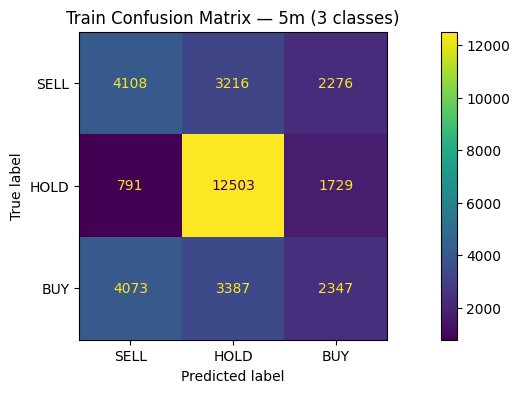


Validation classification report (3 classes present: [0 1 2]):
              precision    recall  f1-score   support

        SELL     0.4449    0.3862    0.4135      2395
        HOLD     0.4791    0.7012    0.5692      2319
         BUY     0.3379    0.2300    0.2737      2378

    accuracy                         0.4368      7092
   macro avg     0.4206    0.4391    0.4188      7092
weighted avg     0.4202    0.4368    0.4175      7092



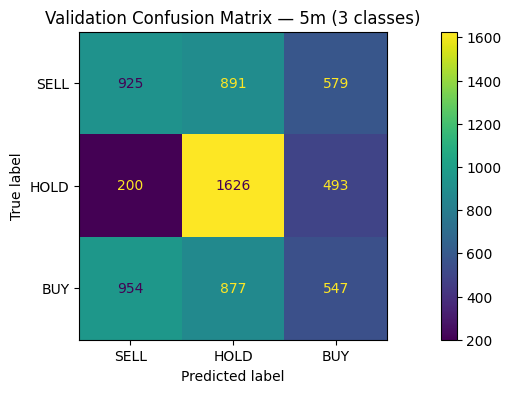

In [ ]:
# Train set evaluation (classification report only)
train_probs = model.predict(X_train_s, verbose=0)
train_pred = train_probs.argmax(axis=1)

unique_classes_train = np.unique(y_train_3)
n_unique_train = len(unique_classes_train)

print(f"Train classification report ({n_unique_train} classes present: {unique_classes_train}):")

if n_unique_train == 3:
    print(classification_report(y_train_3, train_pred, labels=[0, 1, 2], 
                                target_names=["SELL", "HOLD", "BUY"], digits=4))
elif n_unique_train == 2:
    class_names_train = []
    if 0 in unique_classes_train:
        class_names_train.append("SELL")
    if 1 in unique_classes_train:
        class_names_train.append("HOLD")
    if 2 in unique_classes_train:
        class_names_train.append("BUY")
    
    print(classification_report(y_train_3, train_pred, labels=unique_classes_train.tolist(), 
                                target_names=class_names_train, digits=4))
else:
    raise ValueError(f"Unexpected number of unique classes: {n_unique_train}")

# Validation set evaluation
val_probs = model.predict(X_val_s, verbose=0)  # columns: SELL, HOLD, BUY (3-class model)
val_pred = val_probs.argmax(axis=1)

# Check which classes are actually present in validation set
unique_classes = np.unique(y_val_3)
n_unique = len(unique_classes)

print(f"\nValidation classification report ({n_unique} classes present: {unique_classes}):")

if n_unique == 3:
    # All three classes present: SELL (0), HOLD (1), BUY (2)
    print(classification_report(y_val_3, val_pred, labels=[0, 1, 2], 
                                target_names=["SELL", "HOLD", "BUY"], digits=4))
    cm = confusion_matrix(y_val_3, val_pred, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(cm, display_labels=["SELL", "HOLD", "BUY"])
elif n_unique == 2:
    # Only 2 classes present - determine which ones
    class_names = []
    if 0 in unique_classes:
        class_names.append("SELL")
    if 1 in unique_classes:
        class_names.append("HOLD")
    if 2 in unique_classes:
        class_names.append("BUY")
    
    print(classification_report(y_val_3, val_pred, labels=unique_classes.tolist(), 
                                target_names=class_names, digits=4))
    cm = confusion_matrix(y_val_3, val_pred, labels=unique_classes.tolist())
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
else:
    raise ValueError(f"Unexpected number of unique classes: {n_unique}")

disp.plot(values_format="d")
plt.title(f"Validation Confusion Matrix — {HORIZON_MINUTES}m ({n_unique} classes)")
plt.show()

### 6.3b) Test set evaluation


Test classification report (3 classes present: [0 1 2]):
              precision    recall  f1-score   support

        SELL     0.4529    0.4668    0.4597      2819
        HOLD     0.4019    0.4911    0.4420      1743
         BUY     0.3469    0.2858    0.3134      2691

    accuracy                         0.4055      7253
   macro avg     0.4005    0.4146    0.4050      7253
weighted avg     0.4013    0.4055    0.4012      7253



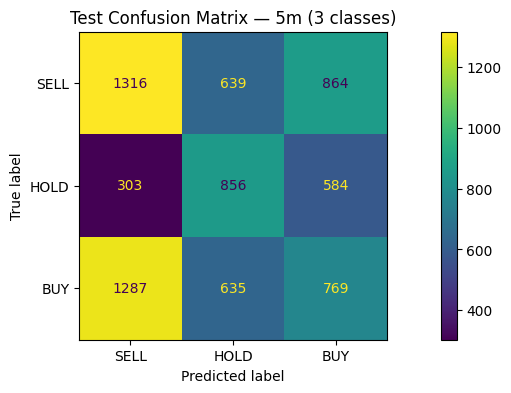

In [173]:
# Test set evaluation
test_probs = model.predict(X_test_s, verbose=0)
test_pred = test_probs.argmax(axis=1)

unique_classes_test = np.unique(y_test_3)
n_unique_test = len(unique_classes_test)

print(f"\nTest classification report ({n_unique_test} classes present: {unique_classes_test}):")

if n_unique_test == 3:
    print(classification_report(y_test_3, test_pred, labels=[0, 1, 2], 
                                target_names=["SELL", "HOLD", "BUY"], digits=4))
    cm_test = confusion_matrix(y_test_3, test_pred, labels=[0, 1, 2])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=["SELL", "HOLD", "BUY"])
elif n_unique_test == 2:
    class_names_test = []
    if 0 in unique_classes_test:
        class_names_test.append("SELL")
    if 1 in unique_classes_test:
        class_names_test.append("HOLD")
    if 2 in unique_classes_test:
        class_names_test.append("BUY")
    
    print(classification_report(y_test_3, test_pred, labels=unique_classes_test.tolist(), 
                                target_names=class_names_test, digits=4))
    cm_test = confusion_matrix(y_test_3, test_pred, labels=unique_classes_test.tolist())
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=class_names_test)
else:
    raise ValueError(f"Unexpected number of unique classes: {n_unique_test}")

disp_test.plot(values_format="d")
plt.title(f"Test Confusion Matrix — {HORIZON_MINUTES}m ({n_unique_test} classes)")
plt.show()

### 6.4) Plot learning curves

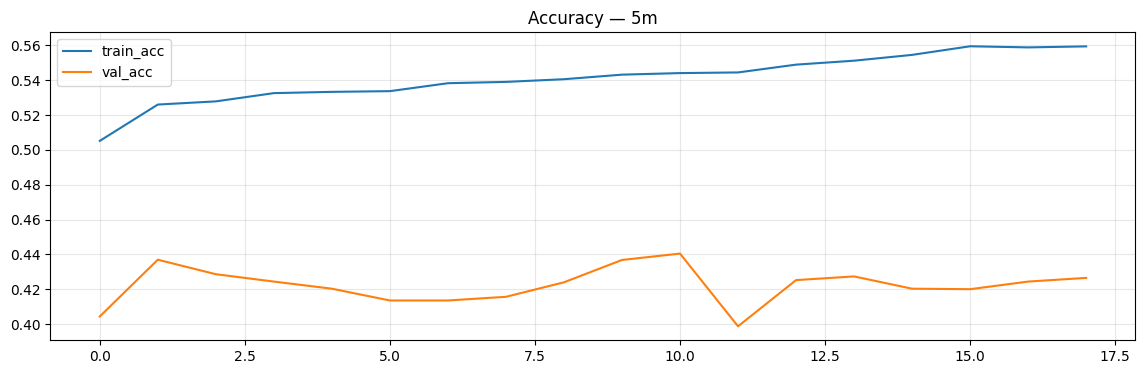

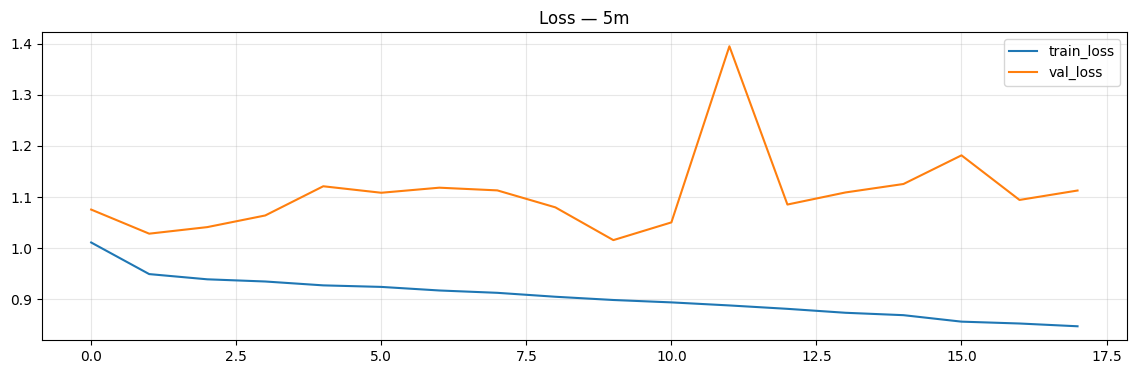

In [174]:
# Plot learning curves
plt.figure(figsize=(14,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title(f"Accuracy — {HORIZON_MINUTES}m")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title(f"Loss — {HORIZON_MINUTES}m")
plt.legend()
plt.grid(alpha=0.3)
plt.show()